# Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
import sklearn

print('Sklearn ver:', sklearn.__version__)

Sklearn ver: 1.1.3


# Import Dataset

In [3]:
df_raw = pd.read_csv('online_shoppers_intention.csv')

## Overview
df_raw.sample(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
9409,0,0.000,0,0.0,11,382.25,0.018182,0.063636,0.0,0.0,Dec,2,2,3,2,Returning_Visitor,False,False
10672,9,73.250,0,0.0,26,2923.25,0.020690,0.037931,0.0,0.0,Dec,1,1,3,1,Returning_Visitor,False,False
9447,0,0.000,0,0.0,1,0.00,0.200000,0.200000,0.0,0.0,Nov,2,4,1,10,Returning_Visitor,True,False
9349,0,0.000,0,0.0,40,1542.35,0.000000,0.031667,0.0,0.0,Nov,2,2,1,2,Returning_Visitor,True,True
9848,6,224.875,0,0.0,21,845.75,0.000000,0.008696,0.0,0.0,Dec,8,13,9,20,Other,False,False


# Data Cleansing

In [4]:
### Copy Raw Dataset
df_clean = df_raw.copy()

## Missing Values

In [5]:
df_clean.isnull().sum().sum()

0

Tidak ada missing value yang perlu ditangani

## Duplicated Rows

In [6]:
df_clean.duplicated().sum()

125

Dari hasil tersebut dapat dilihat bahawa ada 125 data yang duplicat dan data tersebut perlu di hapus

In [7]:
### Menghapus baris duplikat
df_clean.drop_duplicates(inplace=True)

## Handle Outliers

In [8]:
### Fitur dengan outlier ekstrim
feat_w_outl = ['Informational', 'ProductRelated', 'ProductRelated_Duration', 
               'PageValues']

### Coba Drop Outlier
df_no_outl = df_clean.copy()

for i in feat_w_outl:
    q1 = df_no_outl[i].quantile(.25)
    q3 = df_no_outl[i].quantile(.75)
    iqr = q3 - q1
    
    df_no_outl = df_no_outl[(df_no_outl[i] >= q1 - 1.5*iqr) & (df_no_outl[i] <= q3 + 1.5*iqr)]

In [9]:
### Cek dimensi
print('Dimensi sebelum remove outlier:', df_clean.shape)
print('Dimensi setelah remove outlier:', df_no_outl.shape)

### Cek balance target
print('Imbalance sebelum remove outlier')
print(df_clean['Revenue'].value_counts(normalize = True))
print('Imbalance setelah remove outlier')
print(df_no_outl['Revenue'].value_counts(normalize = True))

Dimensi sebelum remove outlier: (12205, 18)
Dimensi setelah remove outlier: (7164, 18)
Imbalance sebelum remove outlier
False    0.843671
True     0.156329
Name: Revenue, dtype: float64
Imbalance setelah remove outlier
False    0.97306
True     0.02694
Name: Revenue, dtype: float64


Setelah remove outlier banyak data target 1 (Revenue True) yang hilang. Mengindikasikan kalau outlier tersebut sebenarnya adalah pola yang wajar. Sehingga outlier tidak kami hilangkan.

## Feature Encoding

In [10]:
### Target
df_clean['Revenue'] = df_clean['Revenue'].astype('int')

### Weekend
df_clean['Weekend'] = df_clean['Weekend'].astype('int')

In [11]:
### Feature engineering untuk fitur-fitur yang banyak unique

### Month
df_clean['Month'] = df_clean['Month'].apply(lambda x : x if x in ['Mar', 'May', 'Nov', 'Dec'] else 'Other')

### OperatingSystem
df_clean['OperatingSystems'] = df_clean['OperatingSystems'].apply(lambda x : x if x in [1, 2, 3] else 'Other')

### Browser
df_clean['Browser'] = df_clean['Browser'].apply(lambda x : x if x in [1, 2] else 'Other')

### Region
df_clean['Region'] = df_clean['Region'].apply(lambda x : x if x in [1, 3] else 'Other')

### TrafficType
df_clean['TrafficType'] = df_clean['TrafficType'].apply(lambda x : x if x in [1, 2, 3] else 'Other')

In [12]:
### One Hot Encoding

### Fitur numerik
num_feat = [feature for feature in df_clean.columns if df_clean[feature].dtypes != 'O' and 
              feature not in ['Weekend', 'Revenue']]

### Fitur kategorik
cat_feat = [feature for feature in df_clean.columns if df_clean[feature].dtypes == 'O']

#### OHE
for i in cat_feat:
    df_ohe = pd.get_dummies(df_clean[i], drop_first=True, prefix = i)
    
    df_clean.drop(i, axis = 1, inplace=True)
    df_clean = pd.concat([df_clean, df_ohe], axis = 1)

## Transformation

In [13]:
### Train Test Split
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_clean, test_size=.2, random_state=42)

In [14]:
### Cek apakah ada fitur numerik yang tidak memuat 0
for i in num_feat:
    if 0 not in df_clean[i].unique():
        print(i)
        
### Transformasi Yeo Johnson (karena semua fitur numerik mengandung 0)
from sklearn.preprocessing import PowerTransformer

for i in num_feat:
    
    pt = PowerTransformer()
    pt.fit(df_train[[i]])
    df_train[i] = pt.transform(df_train[[i]])
    df_test[i] = pt.transform(df_test[[i]])

In [15]:
### Scaling
from sklearn.preprocessing import MinMaxScaler

for i in num_feat:
    sc = MinMaxScaler()
    sc.fit(df_train[[i]])
    df_train[i] = sc.transform(df_train[[i]])
    df_test[i] = sc.transform(df_test[[i]])

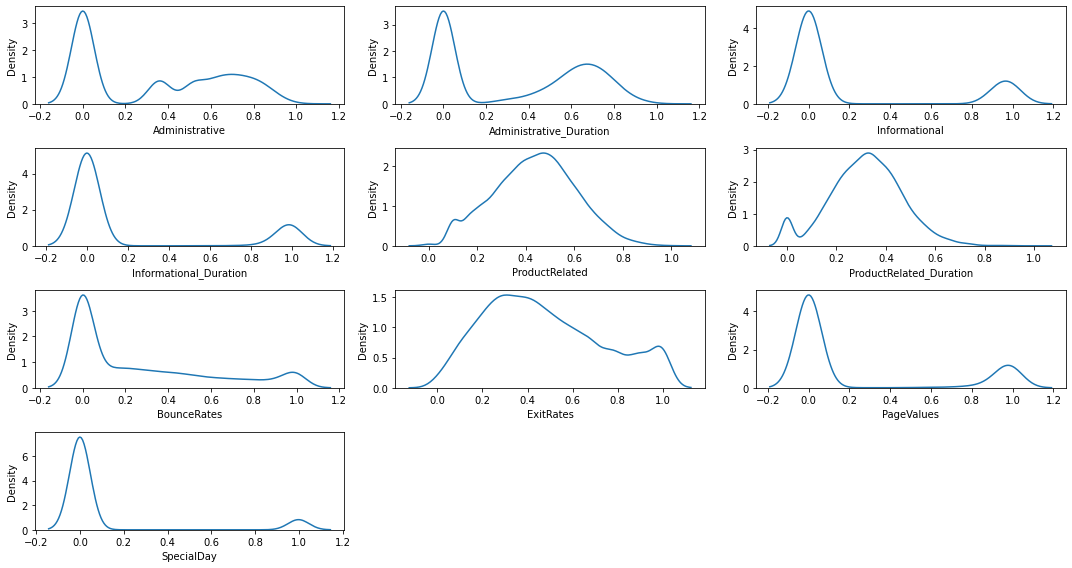

In [16]:
### Cek distribusi setelah transformasi

plt.figure(figsize=(15, 8))
for i in range(0, len(num_feat)):
    plt.subplot(4, 3, i+1)
    sns.kdeplot(df_train[num_feat[i]])
    plt.tight_layout()

Beberapa fitur menjadi lebih normal

## Imbalance

In [17]:
## Cek imbalance
df_train['Revenue'].value_counts(normalize=True)

0    0.841663
1    0.158337
Name: Revenue, dtype: float64

In [18]:
### Over sampling
X_train = df_train.drop('Revenue', axis = 1)
y_train = df_train['Revenue']

from imblearn.over_sampling import SMOTE

X_resample, y_resample = SMOTE(sampling_strategy=0.5, random_state=42).fit_resample(X_train, y_train)

kita mendapatkan imbalance lebih 15% yang msauk kedalam kategori moderate, kami melakukan over sampling menggunakan SMOTE sebanyak 50% agar tidak terjadi overfitting pada data train

In [19]:
df_train = pd.concat([X_resample, y_resample], axis = 1)

df_train.sample(10)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Month_Mar,Month_May,Month_Nov,Month_Other,OperatingSystems_2,OperatingSystems_3,OperatingSystems_Other,Browser_2,Browser_Other,Region_3,Region_Other,TrafficType_2,TrafficType_3,TrafficType_Other,VisitorType_Other,VisitorType_Returning_Visitor,Revenue
11491,0.578051,0.654077,0.922497,0.00000,0.554900,0.478617,0.050150,0.480614,0.986989,0.000000,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,1
6125,0.518830,0.698559,0.000000,0.00000,0.394111,0.297784,0.450501,0.613574,0.000000,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
5360,0.359167,0.349862,0.000000,0.00000,0.462704,0.381300,0.000000,0.281034,0.000000,0.000000,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
2357,0.000000,0.000000,0.000000,0.00000,0.469468,0.297034,0.000000,0.178625,0.978175,0.000000,0,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,0,1
10581,0.307352,0.000000,0.000000,0.00000,0.401241,0.379742,0.494382,0.553745,0.975749,0.144262,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1
2324,0.359167,0.571023,0.000000,0.00000,0.493890,0.351821,0.463409,0.358403,0.990182,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
10704,0.732027,0.725164,0.995608,0.99905,0.535625,0.456527,0.000000,0.111367,0.993308,0.000000,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1
9566,0.359167,0.000000,0.000000,0.00000,0.519813,0.397682,0.701005,0.674648,0.000000,0.999997,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0
11246,0.640476,0.571438,0.000000,0.00000,0.554668,0.465318,0.000000,0.224948,0.987339,0.000000,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
4836,0.614212,0.717909,0.000000,0.00000,0.289545,0.358664,0.000000,0.341638,0.000000,0.000000,1,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0


# Feature Engineering

## Feature Selection

## Feature Extraction

## Additional Features